# Collaboration and Competition

---

In this notebook, I present my MADDPG based solution to the third project, Collaboration and Competition, of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.



## About the enviroment and the agent
The goal of the project is to train two agents to control two rackets to play tennis, i.e. rally the ball over the net. 

### The reward dynamic and the goal of the agent
If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

### State space
The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each variable is represented as a vector of 3 valuess. Therefore, the state received by each agent is described by the 1-D vector of 24 values.
```
Vector Observation space type: continuous
Vector Observation space size (per agent): 8
Number of stacked Vector Observation: 3
```

### Action space
Two continuous actions are available for each racket, corresponding to movement toward (or away from) the net, and jumping. The action values should be between -1 and +1, represented by a vector of 2 values.

### Termination of the episode
The task is episodic. When the episode is terminated (when the ball drops or hit the net), the accumuated score is counted for each agent, and the max score between the two agent is reported as the final score. Note that the episode can go on and on if the agents are so good at it. In training, I have limited each episode to 1000 time steps.

### Success criteria
The agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents).

## The agent (the learning algorithm)
_maddpg_agent.py_ defines the Agent, it learns with the Multi-Agent Deep Deterministic Policy Gradient (MADDPG) method, with Experience Replay and delayed Target Network soft-update techniques.

### About MADDPG
This implementation uses the MADDPG method. The MADDPG is and extension to DDPG, which is capable of handling continuous action spaces and now extended to control multiple agents in collaboration and/or competition environments. The picture below shows the Actor Critic structure of MADDPG
![](https://github.com/hyperZoro/DRLND_projects/blob/main/p3_collab-compet/pic/maddpg.png)
What is important is that while the Actors are decentralised, i.e. they only act based on observations available to them, the Critics are centralised, i.e. they are able to predict rewards with information not only available to them, but also those for other agents, as well as the actions that the other agents are taking. The centralised Critics are the key to MADDPG's ability in working with both collaboration and competition enviroments.

### About Experience Replay
In Deep Q-Learning, Experience Replay is commonly used to break the correlation between consequent states and actions. It is about caching past experiences (action, reward and next state sets), and then sampling them randomly to feed the learning algorithm. In this particular implementation, the experiences from both the agents are stored in pairs. And latter in training, the action and state records are concatenated and fed into the backpropagation for training the Critics.

### About Delayed Target Network
In Deep Q-Learning, Double Q-Network techniques are commonly used, where the target network is updated with delay to stablise Q value estimation. A soft update algorithm is used, where the target network weights are updated with a weighted average of the local network weights and the old target network weights.

### Loss function and optimisation
The Huber loss is used in conjunction with the Adam optimiser.

### Noise add-on
An stochastic zero mean mean reverting random variable (OU Noise) is added to the policy generated actions to exploit un-explored territories (then clipped to between -1 and +1).

### Implementation
_maddpg_agent.py_ bases on _ddpg_agent.py_ from Project 2, and is extended to allow multiple child DDPG agents. The ReplayBuffer class is modified to accommodate data format to store dependent agent experiences, in this case pairs. The _learn()_ method concatenates pairs to feed the Critics accordingly.

## About the models (the neural networks)
_ddpg_model.py_ is written in PyTorch, it defines the Neural Networks. There are 2 different networks - one for the Actor and the other for the Critic. The structure is completely identical to the model from Project 2.

The Actor network is a deep network using 2 fully connected hidden layers (64 nodes each by default, but configurable through parameters _fc1_units_ and _fc2_units_ at initialisation stage) with ELU activations. The input is the enviroment state (in this case a 1D-vector of size 24), while the output is the action (in this case a sized 2 1D-vector of continuous values), with a tanh transform function.

The Critic network is a deep network using 2 fully connected hidden layers. The input is the enviroment state from both agents(Here it is a 1D-vector of size 2 x 24 = 48. I have noticed there are replicated information in the state vector for each agent, i.e. some values are equal or flip-signed, but they are all fed to avoid any over interpretation). The first hidden layer is of size defined by fcs1_units+4 (fcs1_units defaults to 64), because the Network also take the actions from both agents as input. The second layer is of size defined by fc2_units (defaults to 64). Both layers have ELU activation. The final outcome is a scalar (dimension 1), without any transformation. This represents the Q value corresponding to the continuous actions.

## Hyperparameters
The following are the hyperparameters used

  |Hyperparameters|Definition|
  |---------------|------------------------------------------------|
  | _BUFFER_SIZE_ | defines the replay buffer size, default to 1e5 |
  |_BATCH_SIZE_ |defines minibatch size in learning, defaults to 64|
  | _GAMMA_ |defines the discount factor in expected reward calculation, defauls to 0.99|
  |_TAU_ |defines the weights for soft update of target parameters, defaults to 1e-3|
  |_LR_ACTOR_| defines learning rate of the actor, defaults to 2e-4|
  |_LR_CRITIC_| defines learning rate of the critic, defaults to 3e-4|
  |_WEIGHT_DECAY_| defines L2 weight decay, defaults to 0|
  |_LEARN_FREQ_| defines the frequency of learning, defaults to 1|
  |_LEARN_NUM_ |defines the number of times learning is repeated per experience sample set, defaults to 1|

### Saving the trained models
The trained parameters are saved in 4 _.pth_ files, they store trained model parameters that are obtained in one of the training attempts. This particular set in GitHub repo is the first ever success and actually converged quite fast.


## Run the Training Code Below Step by Step
### Start the Environment

We begin by importing the necessary packages and settting the path of the Unity Environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name=r".\Tennis_Windows_x86_64\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### set the environment brain

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the State and Action Spaces


In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Training the agents



In [4]:
from collections import deque
import matplotlib.pyplot as plt
from maddpg_agent import MADDPGAgent
import torch
import time

%matplotlib inline

agent = MADDPGAgent(state_size, action_size, random_seed=1)

Device used:  cpu


In [5]:
def maddpg(n_episodes=3000, max_t=1000, print_every=100, success_criteria_count=100):
    scores_deque = deque(maxlen=success_criteria_count)
    scores = []
    agent_scores = []
    agent_mean_scores_100eps = []

    for i_episode in range(1, n_episodes+1):    
        start_t = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros((num_agents,))   
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]   
            next_state = env_info.vector_observations         
            reward = env_info.rewards                         
            done = env_info.local_done                
            agent.step(state, action, reward, next_state, done, t)
            state = next_state
            score += reward
            if np.any(done):
                break 
            
        scores_deque.append(np.max(score))
        scores.append(score)
        agent_scores.append(np.max(score))
        agent_mean_scores_100eps.append(np.mean(scores_deque))

        end_t = time.time()
               
        if agent_mean_scores_100eps[-1]>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.5f}'.format(i_episode, agent_mean_scores_100eps[-1]), end="")
            torch.save(agent.maddpg_agent[0].actor_local.state_dict(), 'checkpoint_actor_1_maddpg.pth')
            torch.save(agent.maddpg_agent[0].critic_local.state_dict(), 'checkpoint_critic_1_maddpg.pth')
            torch.save(agent.maddpg_agent[1].actor_local.state_dict(), 'checkpoint_actor_2_maddpg.pth')
            torch.save(agent.maddpg_agent[1].critic_local.state_dict(), 'checkpoint_critic_2_maddpg.pth')
            break
        if i_episode % print_every == 0:
            print('Episode {:03d}:\tAgents Mean Score over last 100 episodes: {:.5f} (time per eps:{:.1f} secs)'.format(i_episode, agent_mean_scores_100eps[-1], end_t - start_t), end="\n")
    return scores, agent_scores, agent_mean_scores_100eps

scores, agent_scores, agent_mean_scores_100eps = maddpg()


Episode 100:	Agents Mean Score over last 100 episodes: 0.00000 (time per eps:0.3 secs)
Episode 200:	Agents Mean Score over last 100 episodes: 0.00000 (time per eps:0.3 secs)
Episode 300:	Agents Mean Score over last 100 episodes: 0.00000 (time per eps:0.3 secs)
Episode 400:	Agents Mean Score over last 100 episodes: 0.00100 (time per eps:0.3 secs)
Episode 500:	Agents Mean Score over last 100 episodes: 0.00090 (time per eps:0.3 secs)
Episode 600:	Agents Mean Score over last 100 episodes: 0.00000 (time per eps:0.3 secs)
Episode 700:	Agents Mean Score over last 100 episodes: 0.00100 (time per eps:0.3 secs)
Episode 800:	Agents Mean Score over last 100 episodes: 0.01090 (time per eps:0.3 secs)
Episode 900:	Agents Mean Score over last 100 episodes: 0.01090 (time per eps:0.5 secs)
Episode 1000:	Agents Mean Score over last 100 episodes: 0.00480 (time per eps:0.3 secs)
Episode 1100:	Agents Mean Score over last 100 episodes: 0.02130 (time per eps:0.3 secs)
Episode 1200:	Agents Mean Score over last

Above is progress summary for one of the successful attempts. It is solved in 2450 episodes. But sometimes it can be solved with about 1500 episode. Once the agent gets rather good it start to take a much longer time to get through each episode.

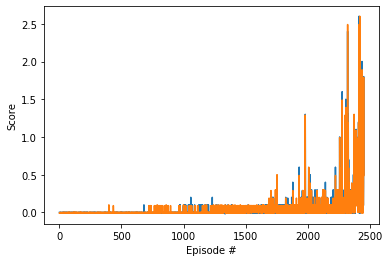

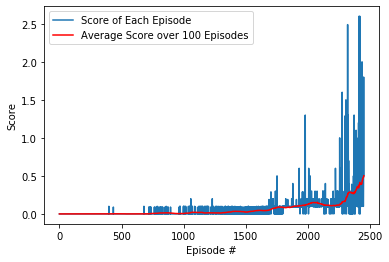

In [8]:
# plot the scores of every agent
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# plot the average scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), agent_scores, label='Score of Each Episode')
plt.plot(np.arange(len(scores)), agent_mean_scores_100eps, c='r', label='Average Score over 100 Episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

### See a Trained Agent in Action
It loads up the stored parameters and runs 6 episodes.

In [10]:
agent.maddpg_agent[0].actor_local.load_state_dict(torch.load('checkpoint_actor_1_maddpg.pth'))
agent.maddpg_agent[1].actor_local.load_state_dict(torch.load('checkpoint_actor_2_maddpg.pth'))

for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states) # select an action (for each agent)
        #actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.10000000149011612
Score (max over agents) from episode 2: 0.20000000298023224
Score (max over agents) from episode 3: 2.600000038743019
Score (max over agents) from episode 4: 1.0000000149011612
Score (max over agents) from episode 5: 2.0000000298023224


### When finished, you can close the environment.

In [11]:
env.reset()
env.close()

## Future Improvement

I found the training process to be rather instable. I have tried various combination of the following
- SGD and Adam optimisers
- Huber and MSE loss
- Various learning rates
- Various neural network dimensions
I have observed sometimes the agent does not improve through training, sometimes one of the racket is stuck while the other is winning every game, etc. So there seem to be many opportunities for improvement by further tweaking these parameters.